In [19]:
TEST_SIZE = 0.3
SEED = 42
BATCH_SIZE = 64 #número de amostras usadas antes de uma atualização dos pesos
EPOCHS = 200
LR = 0.00001 #learning of rate: o tamanho do passo que o otimizador dá ao ajustar os pesos da rede em cada iteração. Quanto o modelo “aprende” de cada vez.

try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader
    TORCH_AVAILABLE = True
except Exception:
    TORCH_AVAILABLE = False
    
import kagglehub as kh
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, matthews_corrcoef, roc_auc_score
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import os
import numpy as np     

import warnings
warnings.filterwarnings('ignore')
sn.set_style('darkgrid', {'axes.facecolor': '0.9'})
    
print(f"Torch disponível: {TORCH_AVAILABLE}")
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Usando dispositivo: {DEVICE}")

import time
import random
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

Torch disponível: True
Usando dispositivo: cpu


In [20]:
path = kh.dataset_download("mlg-ulb/creditcardfraud")
print("Caminho para o Dataset:", path)
os.listdir(path)

df = pd.read_csv(path + "/creditcard.csv")
df.tail()

print('Formato do dataset:', df.shape)
print(df['Class'].value_counts())

expected_pca = [f'V{i}' for i in range(1,29)]
missing = [c for c in expected_pca if c not in df.columns]
if missing:
    print('Aviso: colunas PCA ausentes:', missing)

features = [c for c in df.columns if c != 'Class']
X = df[features].copy()
y = df['Class'].copy()

scaler = StandardScaler()
if 'Amount' in X.columns:
    X['Amount'] = scaler.fit_transform(X[['Amount']])
if 'Time' in X.columns:
    X['Time'] = scaler.fit_transform(X[['Time']])

X = X.fillna(0)


Caminho para o Dataset: /home/ubuntu-user/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3
Formato do dataset: (284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=SEED
)

print('Distribuição treino:\n', y_train.value_counts())
print('Distribuição teste:\n', y_test.value_counts())

Distribuição treino:
 Class
0    199020
1       344
Name: count, dtype: int64
Distribuição teste:
 Class
0    85295
1      148
Name: count, dtype: int64


(-1.1, 1.1)

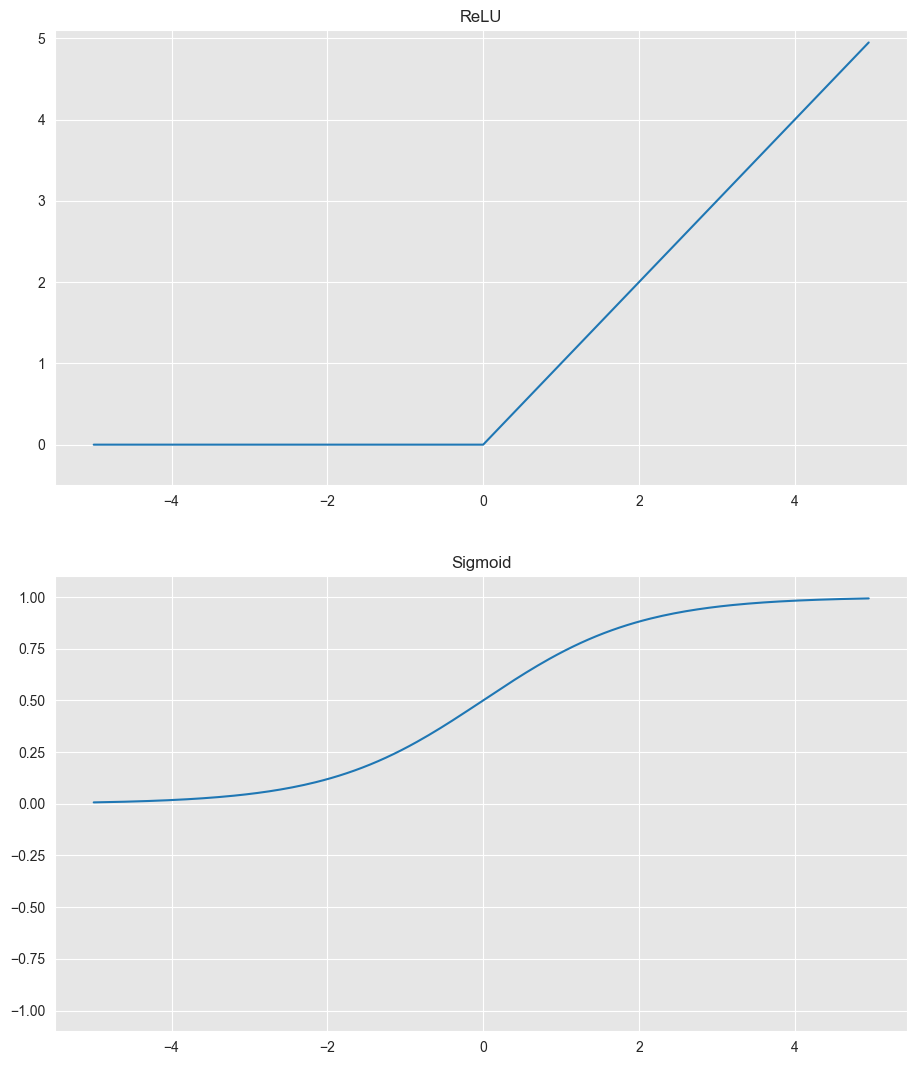

In [22]:
fig_activation, axs = plt.subplots(2,figsize=(11, 13))

input_values = torch.arange(-5, 5, 0.05)

#relu activation
activation = nn.ReLU()
output_values = activation(input_values)
axs[0].plot(input_values, output_values)
axs[0].set_title('ReLU')
axs[0].set_ylim([-0.5,5.1])

#sigmoid activation
activation = nn.Sigmoid()
output_values = activation(input_values)
axs[1].plot(input_values, output_values)
axs[1].set_title('Sigmoid')
axs[1].set_ylim([-1.1,1.1])

In [23]:
def evaluate_model(model,val_loader,criterion):
    model.eval()
    batch_losses = []
    for x_batch, y_batch in val_loader:
        # Forward pass
        y_pred = model(x_batch)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        batch_losses.append(loss.item())
    mean_loss = np.mean(batch_losses)    
    return mean_loss

class EarlyStopping:
    def __init__(self, patience=2):
        self.patience = patience
        self.counter = 0
        self.best_score = np.inf
    
    def continue_training(self,current_score):
        if self.best_score > current_score:
            self.best_score = current_score
            self.counter = 0
            print("New best score:", current_score)
        else:
            self.counter+=1
            print(self.counter, " iterations since best score.")
                
        return self.counter <= self.patience  
    
class FraudDatasetTorch(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = None if y is None else torch.tensor(y.values, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        return self.X[idx], self.y[idx]

class SimpleFraudMLPWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, p=0.2):
        super(SimpleFraudMLPWithDropout, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.p = p
            
        #input to hidden
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.relu = nn.ReLU()
        #hidden to output
        self.fc2 = nn.Linear(self.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
        self.dropout = nn.Dropout(self.p)
            
    def forward(self, x):
        
        hidden = self.fc1(x)
        hidden = self.relu(hidden)
        
        hidden = self.dropout(hidden)
        
        output = self.fc2(hidden)
        output = self.sigmoid(output)
        
        return output

def train_pytorch_mlp(X_tr, y_tr, X_val, y_val, input_size, apply_early_stopping=True, max_epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR, DEVICE=DEVICE):
    model = SimpleFraudMLPWithDropout(input_size, 1000,0.2).to(DEVICE)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_ds = FraudDatasetTorch(X_tr, y_tr) #prepara os dados de treinamento para uso no Torch
    val_ds = FraudDatasetTorch(X_val, y_val) #prepara os dados de teste/validação para uso no Torch
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True) #Facilitar a divisão em lote e aleatoriedade
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False) #Facilitar a divisão em lote
    
    if apply_early_stopping:
        early_stopping = EarlyStopping(patience=5)
    
    model.train()
    all_train_losses = []
    all_valid_losses = []        

    start_time=time.time()
    for epoch in range(max_epochs):
        model.train()
        train_loss=[]
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            # Removing previously computed gradients
            optimizer.zero_grad()
            # Performing the forward pass on the current batch
            preds = model(xb)
            # Computing the loss given the current predictions
            loss = criterion(preds.squeeze(), yb)
            # Computing the gradients over the backward pass
            loss.backward()
            # Performing an optimization step from the current gradients
            optimizer.step()
            # Storing the current step's loss for display purposes
            train_loss.append(loss.item())

        #showing last training loss after each epoch
        all_train_losses.append(np.mean(train_loss))
        print("")        
        print('Epoch {}: train loss: {}'.format(epoch, np.mean(train_loss)))

        #evaluating the model on the test set after each epoch    
        valid_loss = evaluate_model(model,val_loader,criterion)    
        all_valid_losses.append(valid_loss)
        print('valid loss: {}'.format(valid_loss))   
        if apply_early_stopping:
            if not early_stopping.continue_training(valid_loss):
                print("Early stopping")
                break

    training_execution_time=time.time()-start_time
    return model,training_execution_time,all_train_losses,all_valid_losses

def predict_pytorch(model, DEVICE, X):
    model.eval()
    ds = FraudDatasetTorch(X, None)
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False)
    preds = []
    with torch.no_grad():
        for xb in loader:
            xb = xb.to(DEVICE)
            out = model(xb)
            preds.append(out.cpu().numpy())
    return np.concatenate(preds)

def compute_metrics(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    p = precision_score(y_true, y_pred, zero_division=0)
    r = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else np.nan
    return dict(accuracy=acc, precision=p, recall=r, f1=f1, mcc=mcc, auc=auc)


In [24]:
summary_rows_train = []
summary_rows = []
roc_data = {}

print('Original')
model,training_execution_time,train_losses,valid_losses = train_pytorch_mlp(X_train, y_train, X_test, y_test, input_size=X_train.shape[1], apply_early_stopping=True)
print(training_execution_time)

y_proba_train = predict_pytorch(model, DEVICE, X_train)
y_pred_train = (y_proba_train >= 0.5).astype(int)
y_proba = predict_pytorch(model, DEVICE, X_test)
y_pred = (y_proba >= 0.5).astype(int)

metricsTrain = compute_metrics(y_train, y_pred_train, y_proba_train)
summary_rows_train.append(dict(ratio='Original', model='FNN_train', **metricsTrain))
metricsTest = compute_metrics(y_test, y_pred, y_proba)
summary_rows.append(dict(ratio='Original', model='FNN', **metricsTest))
roc_data["Original"] = y_proba_train
roc_data["Original"] = y_proba

Original

Epoch 0: train loss: 0.19169267740122142
valid loss: 0.05207293607924736
New best score: 0.05207293607924736

Epoch 1: train loss: 0.032725283136099355
valid loss: 0.019522350946856764
New best score: 0.019522350946856764

Epoch 2: train loss: 0.012584469672002553
valid loss: 0.008546680406162594
New best score: 0.008546680406162594

Epoch 3: train loss: 0.006684666224839782
valid loss: 0.006220050711398401
New best score: 0.006220050711398401

Epoch 4: train loss: 0.005164522303830813
valid loss: 0.005504444952149531
New best score: 0.005504444952149531

Epoch 5: train loss: 0.004589755565679524
valid loss: 0.005132132105555972
New best score: 0.005132132105555972

Epoch 6: train loss: 0.004227319781129223
valid loss: 0.004812028550578269
New best score: 0.004812028550578269

Epoch 7: train loss: 0.00393173391871636
valid loss: 0.004553845542949477
New best score: 0.004553845542949477

Epoch 8: train loss: 0.0036594671610134504
valid loss: 0.004311121800172172
New best score

In [25]:
summary_df_train = pd.DataFrame(summary_rows_train)
summary_df = pd.DataFrame(summary_rows)


Resumo das métricas:
      ratio      model  accuracy  precision    recall        f1      mcc  \
0  Original  FNN_train  0.999609   0.946309  0.819767  0.878505  0.88058   

        auc  
0  0.995215  
      ratio model  accuracy  precision    recall        f1       mcc       auc
0  Original   FNN  0.999391      0.875  0.756757  0.811594  0.813436  0.978444


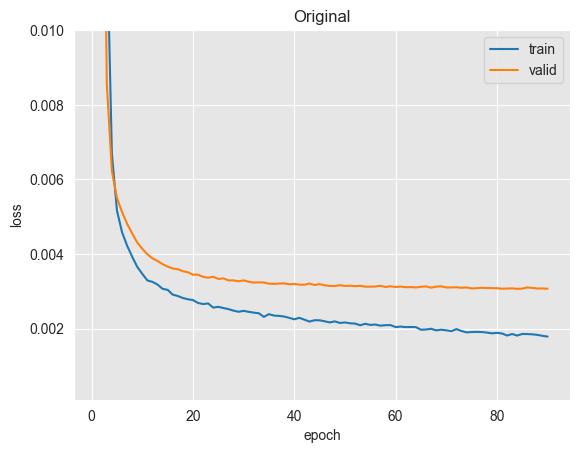

In [26]:
plt.plot(np.arange(len(train_losses))+1, train_losses)
plt.plot(np.arange(len(valid_losses))+1, valid_losses)
plt.title("Original")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.ylim(0.0001,0.01) 

print('\nResumo das métricas:')
print(summary_df_train)
print(summary_df)

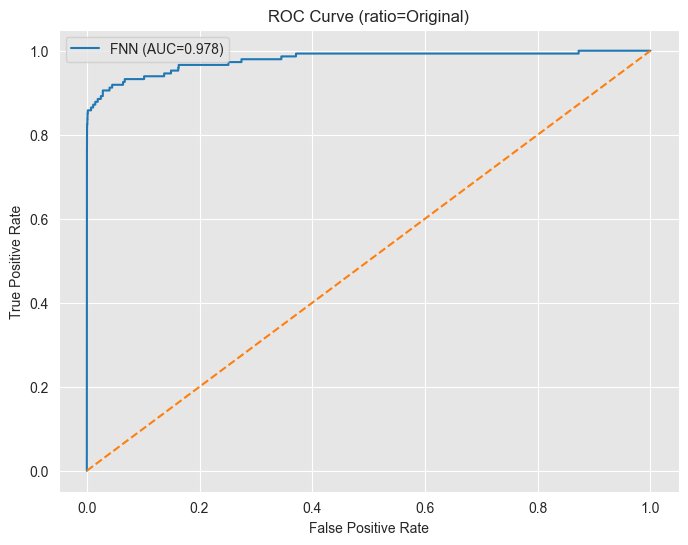

In [27]:
last_ratio = list(roc_data.keys())[-1]
plt.figure(figsize=(8,6))
fpr, tpr, _ = roc_curve(y_test, roc_data[last_ratio])
auc_val = roc_auc_score(y_test, roc_data[last_ratio])
plt.plot(fpr, tpr, label=f"FNN (AUC={auc_val:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (ratio={last_ratio})')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
print('SMOTE-ENN 10 : 90')
smt = SMOTEENN(random_state=42, sampling_strategy=0.111)
X_train_sm_1090, y_train_sm_1090 = smt.fit_resample(X_train, y_train)

print('Amostra balanceada:', np.bincount(y_train_sm_1090.astype(int)))
model,training_execution_time_sm_1090,train_losses_sm_1090,valid_losses_sm_1090 = train_pytorch_mlp(X_train, y_train, X_test, y_test, input_size=X_train.shape[1], apply_early_stopping=True)
print(training_execution_time_sm_1090)

y_proba_train_sm_1090 = predict_pytorch(model, DEVICE, X_train_sm_1090)
y_pred_train_sm_1090 = (y_proba_train_sm_1090 >= 0.5).astype(int)
y_proba = predict_pytorch(model, DEVICE, X_test)
y_pred = (y_proba >= 0.5).astype(int)

metricsTrain = compute_metrics(y_train_sm_1090, y_pred_train_sm_1090, y_proba_train_sm_1090)
summary_rows_train.append(dict(ratio=f"{10}:{90}", model='FNN_train', **metricsTrain))
metricsTest = compute_metrics(y_test, y_pred, y_proba)
summary_rows.append(dict(ratio=f"{10}:{90}", model='FNN', **metricsTest))
roc_data[f"{10}:{90}"] = y_proba_train
roc_data[f"{10}:{90}"] = y_proba

SMOTE-ENN 10 : 90
Amostra balanceada: [198704  22082]

Epoch 0: train loss: 0.15849457024530877
valid loss: 0.04597623425000487
New best score: 0.04597623425000487

Epoch 1: train loss: 0.02938553693884235
valid loss: 0.01776242953401706
New best score: 0.01776242953401706

Epoch 2: train loss: 0.011500298531486298
valid loss: 0.008114882484395586
New best score: 0.008114882484395586

Epoch 3: train loss: 0.006574416900235492
valid loss: 0.0061209796827922935
New best score: 0.0061209796827922935

Epoch 4: train loss: 0.005220343273819576
valid loss: 0.0054748310406406864
New best score: 0.0054748310406406864

Epoch 5: train loss: 0.004629320011686624
valid loss: 0.005113082391023078
New best score: 0.005113082391023078

Epoch 6: train loss: 0.004234009294430154
valid loss: 0.0048333140342304804
New best score: 0.0048333140342304804

Epoch 7: train loss: 0.003957477777481852
valid loss: 0.004584786695587044
New best score: 0.004584786695587044

Epoch 8: train loss: 0.003704223314378860

In [29]:
summary_df_train = pd.DataFrame(summary_rows_train)
summary_df = pd.DataFrame(summary_rows)

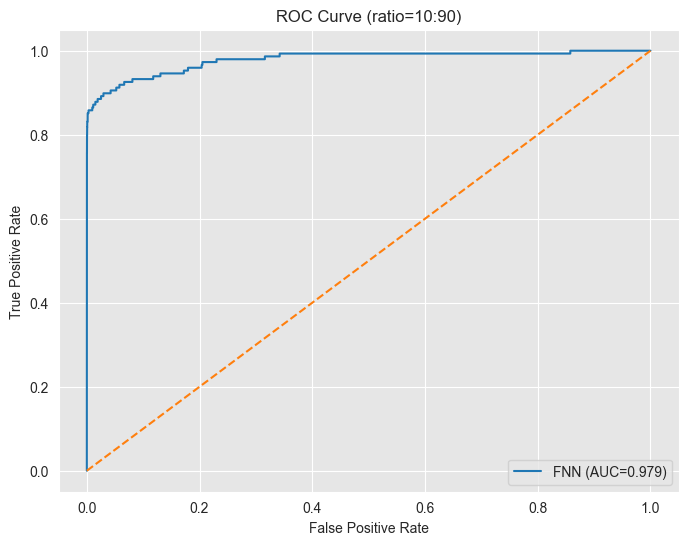

In [30]:
last_ratio = list(roc_data.keys())[-1]
plt.figure(figsize=(8,6))
fpr, tpr, _ = roc_curve(y_test, roc_data[last_ratio])
auc_val = roc_auc_score(y_test, roc_data[last_ratio])
plt.plot(fpr, tpr, label=f"FNN (AUC={auc_val:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (ratio={last_ratio})')
plt.legend()
plt.grid(True)
plt.show()


Resumo das métricas:
      ratio      model  accuracy  precision    recall        f1       mcc  \
0  Original  FNN_train  0.999609   0.946309  0.819767  0.878505  0.880580   
1     10:90  FNN_train  0.983237   0.999891  0.832488  0.908543  0.903976   

        auc  
0  0.995215  
1  0.997165  
      ratio model  accuracy  precision    recall        f1       mcc       auc
0  Original   FNN  0.999391   0.875000  0.756757  0.811594  0.813436  0.978444
1     10:90   FNN  0.999356   0.849624  0.763514  0.804270  0.805101  0.978523


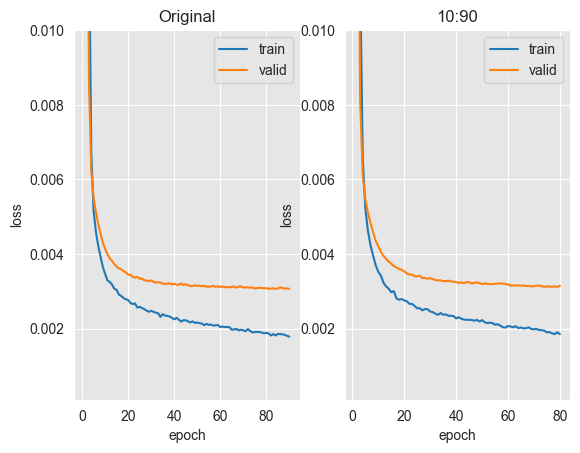

In [31]:
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(train_losses))+1, train_losses)
plt.plot(np.arange(len(valid_losses))+1, valid_losses)
plt.title("Original")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.ylim(0.0001,0.01) 

plt.subplot(1, 2, 2) 
plt.plot(np.arange(len(train_losses_sm_1090))+1, train_losses_sm_1090)
plt.plot(np.arange(len(valid_losses_sm_1090))+1, valid_losses_sm_1090)
plt.title("10:90")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.ylim(0.0001,0.01) 

print('\nResumo das métricas:')
print(summary_df_train)
print(summary_df)

In [32]:
print('SMOTE-ENN 50 : 50')
smt = SMOTEENN(random_state=42)
X_train_sm_5050, y_train_sm_5050 = smt.fit_resample(X_train, y_train)

print('Amostra balanceada:', np.bincount(y_train_sm_5050.astype(int)))
model,training_execution_time_sm_5050,train_losses_sm_5050,valid_losses_sm_5050 = train_pytorch_mlp(X_train, y_train, X_test, y_test, input_size=X_train.shape[1], apply_early_stopping=True)
print(training_execution_time_sm_5050)

y_proba_train_sm_5050 = predict_pytorch(model, DEVICE, X_train_sm_5050)
y_pred_train_sm_5050 = (y_proba_train_sm_5050 >= 0.5).astype(int)
y_proba = predict_pytorch(model, DEVICE, X_test)
y_pred = (y_proba >= 0.5).astype(int)

metricsTrain = compute_metrics(y_train_sm_5050, y_pred_train_sm_5050, y_proba_train_sm_5050)
summary_rows_train.append(dict(ratio=f"{50}:{50}", model='FNN_train', **metricsTrain))
metrics = compute_metrics(y_test, y_pred, y_proba)
summary_rows.append(dict(ratio=f"{50}:{50}", model='FNN', **metrics))
roc_data[f"{50}:{50}"] = y_proba_train
roc_data[f"{50}:{50}"] = y_proba

SMOTE-ENN 50 : 50
Amostra balanceada: [198689 199020]

Epoch 0: train loss: 0.19657974765995884
valid loss: 0.05327440328857008
New best score: 0.05327440328857008

Epoch 1: train loss: 0.033338480435947816
valid loss: 0.019642955383416934
New best score: 0.019642955383416934

Epoch 2: train loss: 0.012661540157798874
valid loss: 0.0085638310231511
New best score: 0.0085638310231511

Epoch 3: train loss: 0.006877750844510262
valid loss: 0.006383381865653391
New best score: 0.006383381865653391

Epoch 4: train loss: 0.005482300455642826
valid loss: 0.005661725562892249
New best score: 0.005661725562892249

Epoch 5: train loss: 0.0047335711918238205
valid loss: 0.005239917289559425
New best score: 0.005239917289559425

Epoch 6: train loss: 0.004377696575969861
valid loss: 0.004916643430258414
New best score: 0.004916643430258414

Epoch 7: train loss: 0.004005612562642468
valid loss: 0.004632692699841956
New best score: 0.004632692699841956

Epoch 8: train loss: 0.0038273935757231797
vali

In [33]:
summary_df_train = pd.DataFrame(summary_rows_train)
summary_df = pd.DataFrame(summary_rows)

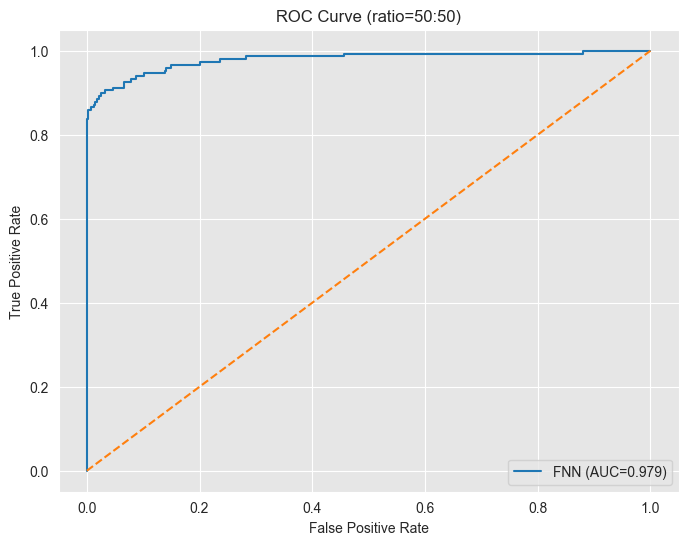

In [34]:
last_ratio = list(roc_data.keys())[-1]
plt.figure(figsize=(8,6))
fpr, tpr, _ = roc_curve(y_test, roc_data[last_ratio])
auc_val = roc_auc_score(y_test, roc_data[last_ratio])
plt.plot(fpr, tpr, label=f"FNN (AUC={auc_val:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (ratio={last_ratio})')
plt.legend()
plt.grid(True)
plt.show()


Resumo das métricas:
      ratio      model  accuracy  precision    recall        f1       mcc  \
0  Original  FNN_train  0.999609   0.946309  0.819767  0.878505  0.880580   
1     10:90  FNN_train  0.983237   0.999891  0.832488  0.908543  0.903976   
2     50:50  FNN_train  0.922152   0.999994  0.844438  0.915656  0.854743   

        auc  
0  0.995215  
1  0.997165  
2  0.997514  
      ratio model  accuracy  precision    recall        f1       mcc       auc
0  Original   FNN  0.999391   0.875000  0.756757  0.811594  0.813436  0.978444
1     10:90   FNN  0.999356   0.849624  0.763514  0.804270  0.805101  0.978523
2     50:50   FNN  0.999380   0.868217  0.756757  0.808664  0.810270  0.979264


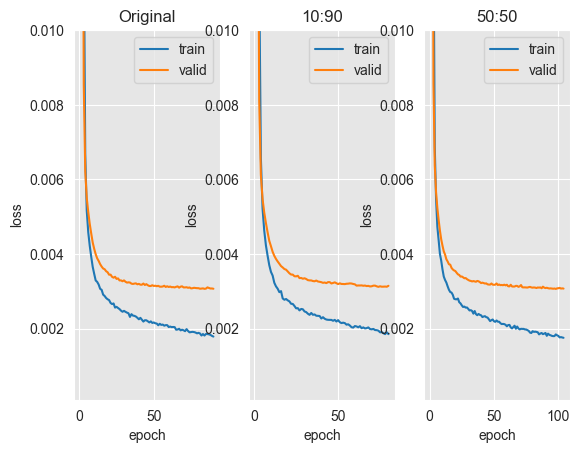

In [35]:
plt.subplot(1, 3, 1)
plt.plot(np.arange(len(train_losses))+1, train_losses)
plt.plot(np.arange(len(valid_losses))+1, valid_losses)
plt.title("Original")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.ylim(0.0001,0.01) 

plt.subplot(1, 3, 2) 
plt.plot(np.arange(len(train_losses_sm_1090))+1, train_losses_sm_1090)
plt.plot(np.arange(len(valid_losses_sm_1090))+1, valid_losses_sm_1090)
plt.title("10:90")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.ylim(0.0001,0.01) 

plt.subplot(1, 3, 3) 
plt.plot(np.arange(len(train_losses_sm_5050))+1, train_losses_sm_5050)
plt.plot(np.arange(len(valid_losses_sm_5050))+1, valid_losses_sm_5050)
plt.title("50:50")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.ylim(0.0001,0.01) 

print('\nResumo das métricas:')
print(summary_df_train)
print(summary_df)

In [36]:
summary_df.to_csv('fnn_results_summary.csv', index=False)
print('Resultados salvos em fnn_results_summary.csv')

Resultados salvos em fnn_results_summary.csv
